# Model Evaluation

In [1]:
import os
os.environ["TPOT_USE_DASK"] = "False"

# 2. Import Standard Libraries
We import libraries for data analysis (`pandas`, `numpy`), and visualization (`matplotlib`, `seaborn`).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Machine Learning Imports
We load classifiers, model selection tools, evaluation metrics, and preprocessing transformers from `scikit-learn`. We also import `TfidfVectorizer` for converting text to numeric features.

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve
)
from sklearn.preprocessing import StandardScaler

# 4. Sparse Matrix Utilities
TF-IDF often returns sparse matrices. We use `scipy.sparse` tools to manipulate and combine them efficiently.

In [10]:
from scipy.sparse import hstack, csr_matrix

# 5. Class Balancing with imbalanced-learn
We use SMOTE (Synthetic Minority Over-sampling Technique) to handle class imbalance. It creates synthetic examples of the minority class to balance the dataset.

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# 6. Text Preprocessing
We use the NLTK library for tokenization and stopword removal. This helps clean up text data before vectorization.

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rsalvatori/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rsalvatori/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

In [19]:
def plot_confusion_matrix(cm, model_name, threshold):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}\\nThreshold: {threshold:.3f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

In [24]:
def plot_roc_curves(results):
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(result['y_test'], result['probabilities'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [26]:
def plot_precision_recall_curves(results):
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        precision, recall, _ = precision_recall_curve(result['y_test'], result['probabilities'])
        plt.plot(recall, precision, label=f'{name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
def plot_metrics_comparison(results):
    metrics = ['precision', 'recall', 'f1', 'roc_auc']
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    for idx, metric in enumerate(metrics):
        values = [result[metric] for result in results.values()]
        names = list(results.keys())
        sns.barplot(x=names, y=values, ax=axes[idx])
        axes[idx].set_title(f'{metric.capitalize()} Comparison')
        axes[idx].set_ylim(0, 1)
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

### Feature Importance Plot
Only for tree-based models. Displays which features influenced the model the most.


In [31]:
def plot_feature_importance(model, feature_names, top_n=20):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importances')
        plt.bar(range(top_n), importances[indices[:top_n]])
        plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# 7. Text Cleaning Pipeline
- Lowercases text
- Removes punctuation and digits
- Removes stopwords
- Tokenizes


In [34]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\\s]', '', text)
        text = ' '.join(text.split())
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [t for t in tokens if t not in stop_words]
        return ' '.join(tokens)
    return ''

# 8. Data Loading and Preprocessing
- Loads CSV
- Cleans text
- TF-IDF on combined text
- Scales numeric features
- Encodes categorical features
- Combines all into a feature matrix


In [37]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    print("\Class distribution in dataset:")
    print(df['label'].value_counts(normalize=True))

    text_features = ['statement', 'statement-raw', 'statement-lemmatize']
    numeric_features = ['feelings'] + [col for col in df.columns if col.startswith('subject-')]
    categorical_features = [col for col in df.columns if col not in text_features + numeric_features + ['id', 'label']]

    for feature in text_features:
        df[feature] = df[feature].apply(preprocess_text)

    df['combined_text'] = df[text_features].apply(lambda x: ' '.join(x.dropna()), axis=1)

    tfidf = TfidfVectorizer(min_df=1, max_df=0.95, max_features=500, ngram_range=(1, 2))
    text_features_tfidf = tfidf.fit_transform(df['combined_text'])

    scaler = StandardScaler()
    numeric_features_scaled = scaler.fit_transform(df[numeric_features].astype(float))
    categorical_dummies = pd.get_dummies(df[categorical_features], drop_first=True)

    X = np.hstack([
        text_features_tfidf.toarray(),
        numeric_features_scaled,
        categorical_dummies.values
    ])
    y = df['label']

    feature_names = (
        [f'text_{i}' for i in range(text_features_tfidf.shape[1])] +
        numeric_features +
        categorical_dummies.columns.tolist()
    )

    return X, y, tfidf, scaler, feature_names

# 9. Find Best Threshold using F-beta score
Helps customize the precision-recall tradeoff.


In [40]:
def find_optimal_threshold(y_true, y_pred_proba, beta=1):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)
    f_beta_scores = ((1 + beta**2) * precisions * recalls) / ((beta**2 * precisions) + recalls + 1e-10)
    optimal_threshold = thresholds[np.argmax(f_beta_scores)]
    # Ensure we don't get extreme thresholds
    if optimal_threshold < 0.3:
        optimal_threshold = 0.3
    elif optimal_threshold > 0.7:
        optimal_threshold = 0.7
        
    return optimal_threshold


# 10. Train Models
We define and train:
- Random Forest
- Gradient Boosting
- Linear SVM
- Soft Voting Ensemble

Each model's predictions are threshold-optimized and evaluated.


In [43]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names):
    """Train and evaluate multiple models with optimized parameters"""
    # Define base models with lighter parameters for faster comparison
    models = {
        'rf': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight={0: 2, 1: 1},  # Give more weight to negative class
            random_state=42,
            n_jobs=-1
        ),
        'gb': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ),
        'dt': DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight={0: 2, 1: 1},  # Give more weight to negative class
            random_state=42
        ),
        'knn': KNeighborsClassifier(
            n_neighbors=5,
            weights='distance',
            n_jobs=-1
        ),
        'mlp': MLPClassifier(
            hidden_layer_sizes=(100,),
            max_iter=200,
            random_state=42
        ),
        'svm_linear': SVC(
            probability=True,
            class_weight={0: 2, 1: 1},  # Give more weight to negative class
            kernel='linear',
            random_state=42
        ),
        'svm_rbf': SVC(
            probability=True,
            class_weight={0: 2, 1: 1},  # Give more weight to negative class
            kernel='rbf',
            random_state=42
        ),
        'lr': LogisticRegression(
            class_weight={0: 2, 1: 1},  # Give more weight to negative class
            max_iter=200,
            random_state=42,
            n_jobs=-1
        ),
        'nb': GaussianNB()
    }
    
    # Add XGBoost if available
    if xgb_available:
        models['xgb'] = XGBClassifier(
            n_estimators=100,
            max_depth=5,
            scale_pos_weight=2,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        )
    
    # Create ensemble with all models
    ensemble = VotingClassifier(
        estimators=[(name, model) for name, model in models.items()],
        voting='soft',
        weights=[2, 1, 1, 1, 1, 1, 1, 1, 1] + ([1] if xgb_available else [])
    )
    
    # Train models
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        try:
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Find optimal threshold with beta=1 for balanced precision/recall
            optimal_threshold = find_optimal_threshold(y_test, y_pred_proba, beta=1)
            y_pred = (y_pred_proba >= optimal_threshold).astype(int)
            
            # Calculate metrics
            results[name] = {
                'model': model,
                'threshold': optimal_threshold,
                'predictions': y_pred,
                'probabilities': y_pred_proba,
                'y_test': y_test,
                'report': classification_report(y_test, y_pred),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_pred_proba),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred)
            }
            
            # Plot confusion matrix
            plot_confusion_matrix(results[name]['confusion_matrix'], name, optimal_threshold)
            
            # Plot feature importance only for tree-based models
            if name in ['rf', 'gb', 'dt'] and hasattr(model, 'feature_importances_'):
                plot_feature_importance(model, feature_names)
                
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            continue
    
    # Train and evaluate ensemble
    print("\nTraining ensemble...")
    try:
        ensemble.fit(X_train, y_train)
        y_pred_proba = ensemble.predict_proba(X_test)[:, 1]
        optimal_threshold = find_optimal_threshold(y_test, y_pred_proba, beta=1)
        y_pred = (y_pred_proba >= optimal_threshold).astype(int)
        
        results['ensemble'] = {
            'model': ensemble,
            'threshold': optimal_threshold,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'y_test': y_test,
            'report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }
        
        # Plot confusion matrix for ensemble
        plot_confusion_matrix(results['ensemble']['confusion_matrix'], 'Ensemble', optimal_threshold)
        
    except Exception as e:
        print(f"Error training ensemble: {str(e)}")
    
    # Plot comparison plots
    plot_roc_curves(results)
    plot_precision_recall_curves(results)
    plot_metrics_comparison(results)
    
    return results

In [45]:
X, y, tfidf, scaler, feature_names = load_and_preprocess_data('formated/train_exportado.csv')

\Class distribution in dataset:
label
1    0.647486
0    0.352514
Name: proportion, dtype: float64


In [47]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
# Apply SMOTE with reduced sampling
smote = SMOTE(random_state=42, sampling_strategy=0.8)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Class distribution after SMOTE:
label
1    0.555609
0    0.444391
Name: proportion, dtype: float64



Training rf...


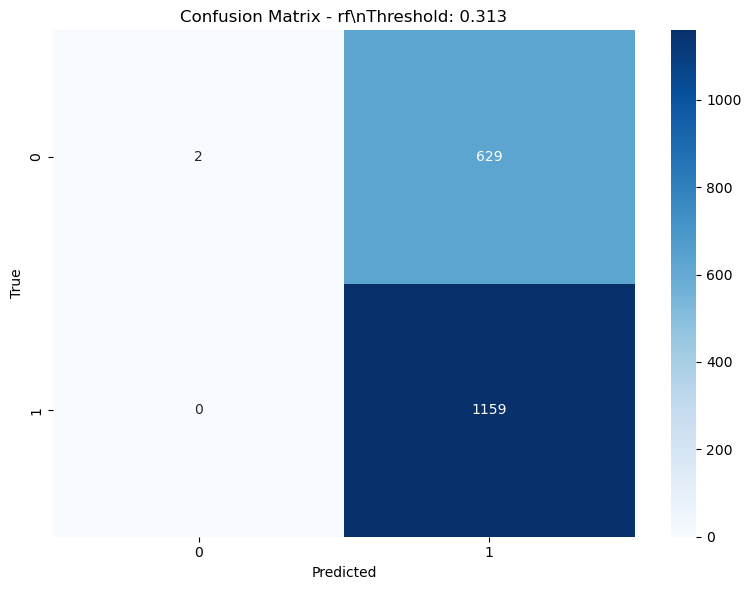

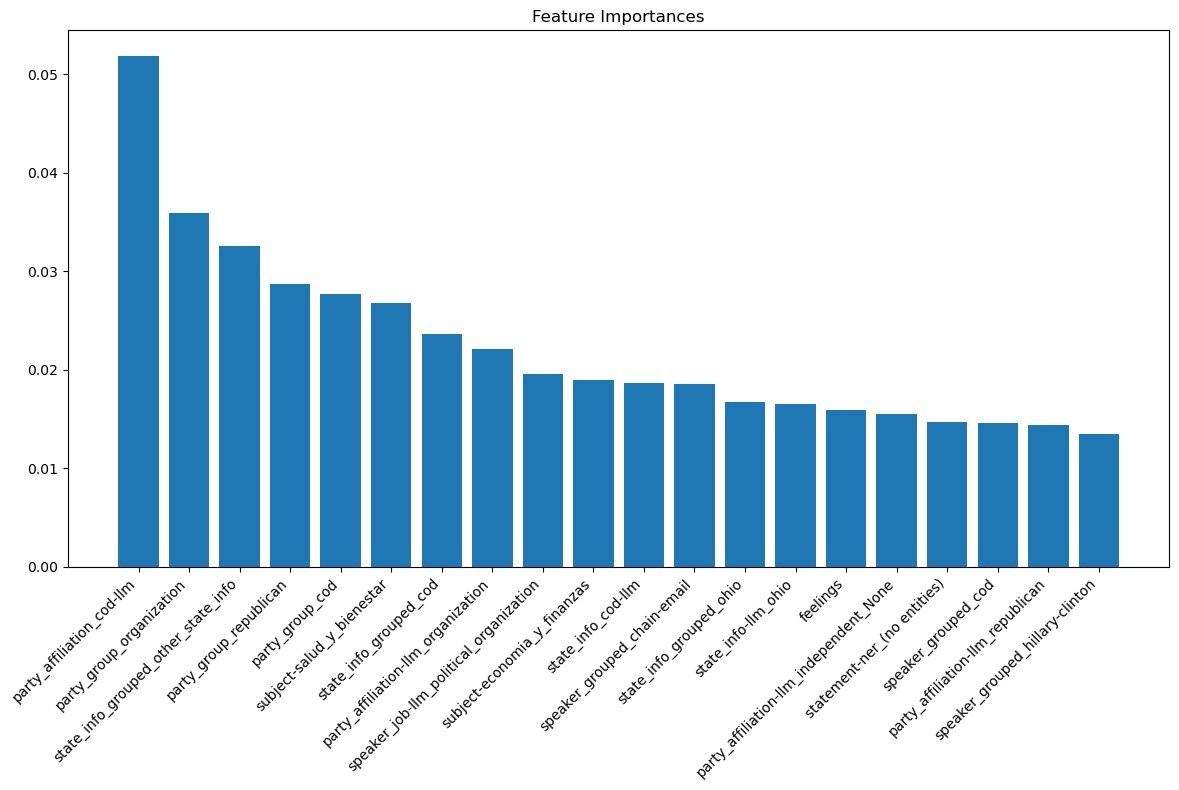


Training gb...


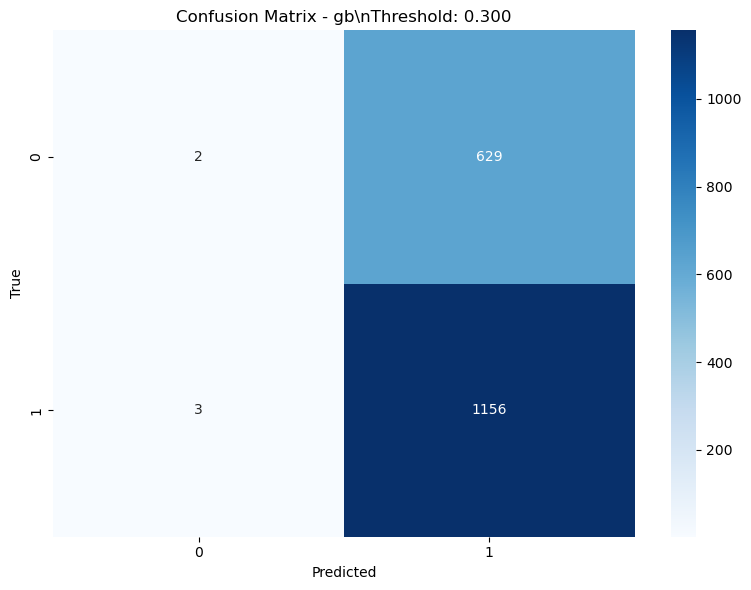

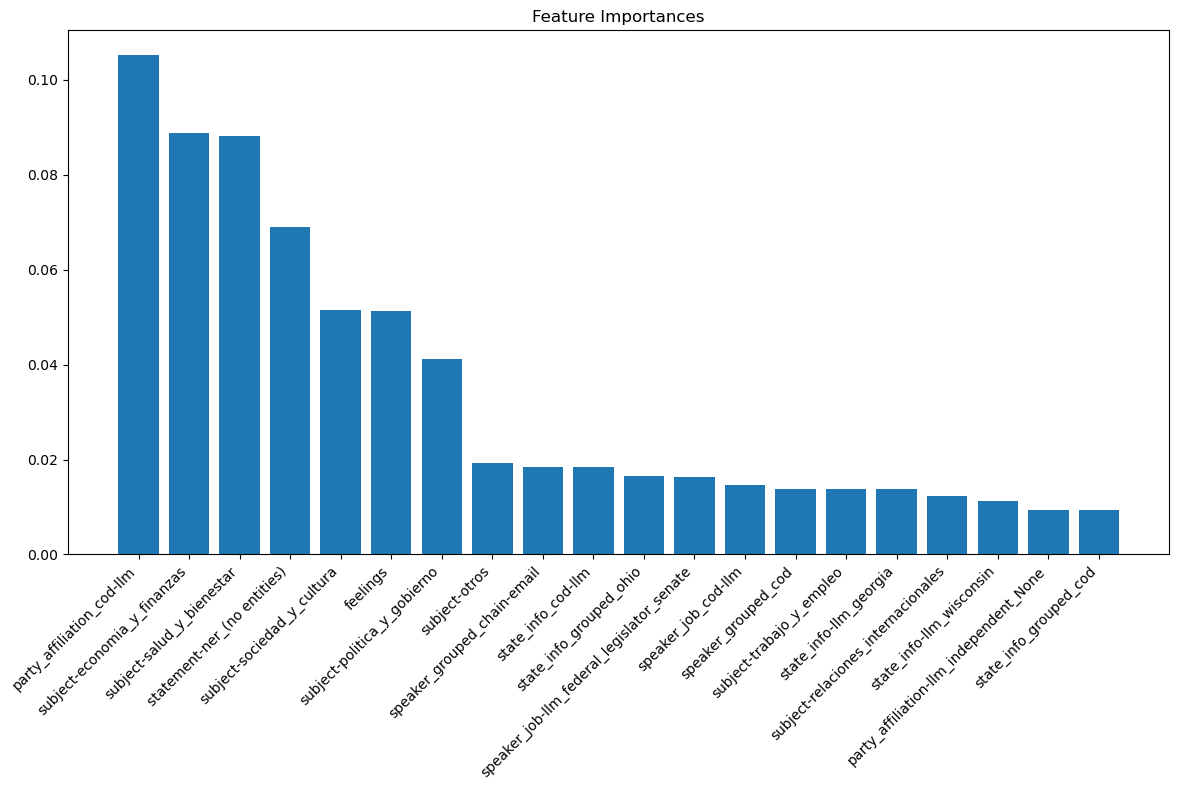


Training dt...


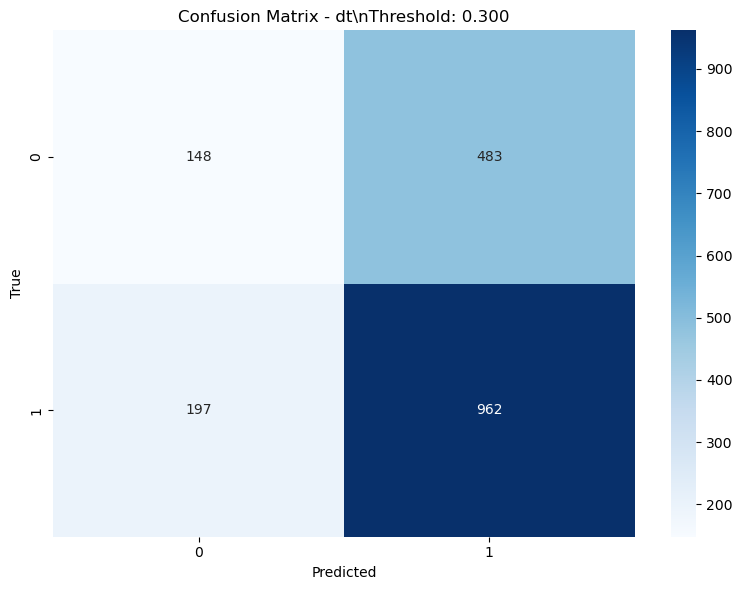

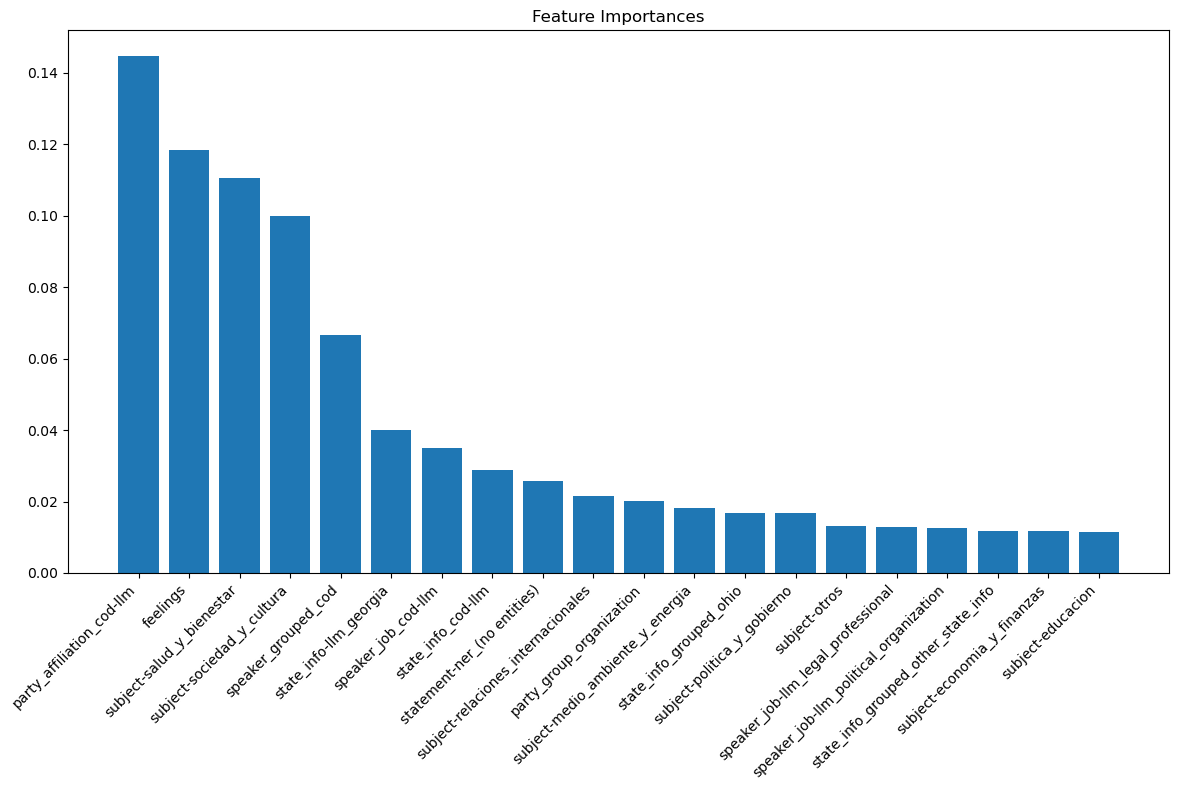


Training knn...


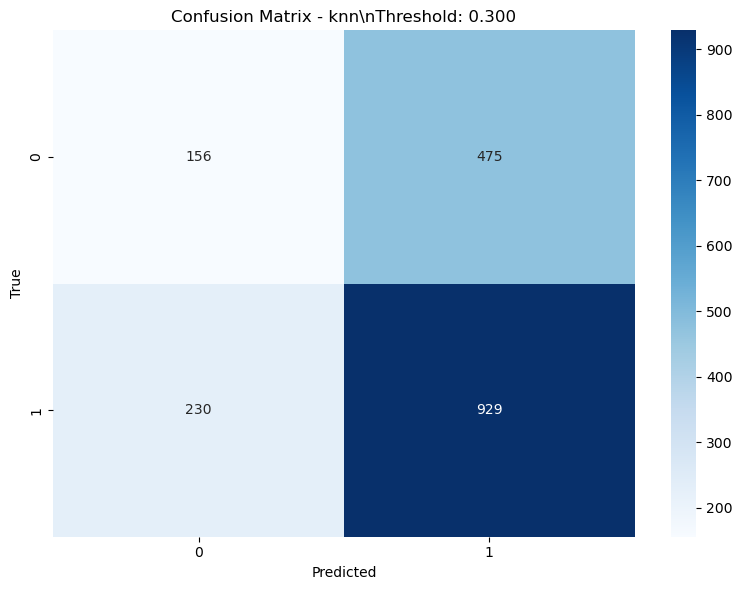


Training mlp...


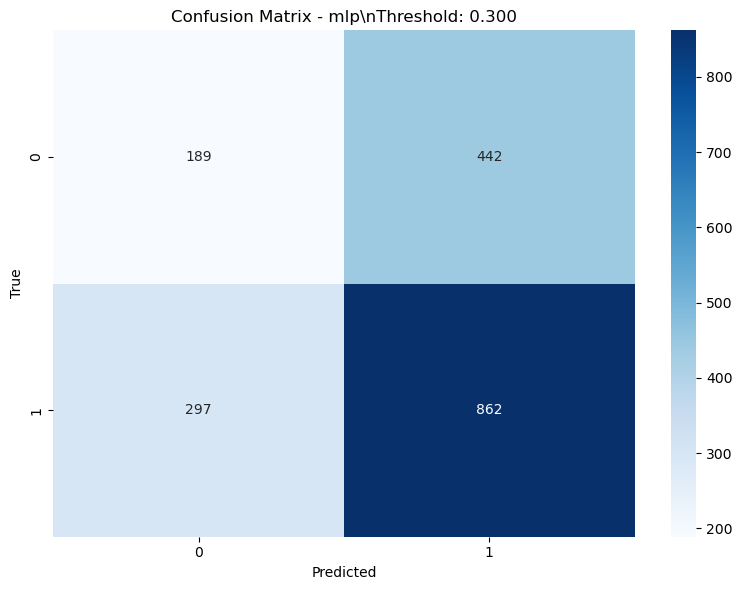


Training svm_linear...


In [ ]:
# Train and evaluate models
results = train_and_evaluate_models(X_train_resampled, X_test, y_train_resampled, y_test, feature_names)

In [ ]:
for name, result in results.items():
    print(f"\nResults for {name}:")
    print(f"Optimal threshold: {result['threshold']:.3f}")
    print(f"ROC AUC: {result['roc_auc']:.3f}")
    print("\nClassification Report:")
    print(result['report'])
    print("\nConfusion Matrix:")
    print(result['confusion_matrix'])